In [ ]:
#default_exp data.transforms

In [ ]:
# hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

nbdev_path = str(NbdevConfig().path("nbs_path")/'data')
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

# Transform
> Factory methods for creating `Transformations` for a ImageDataset.

This library currently supports transformations from `torchvision`, `timm` & `albumentations`

In [ ]:
# export
from abc import ABC, abstractmethod
from typing import List, Callable, Dict, Union, Tuple, Optional
import math

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision.transforms as T

from timm.data.transforms import RandomResizedCropAndInterpolation, _pil_interp
from timm.data.random_erasing import RandomErasing
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, DEFAULT_CROP_PCT

from fastcore.all import ifnone, basic_repr, delegates
from omegaconf import DictConfig
from hydra.utils import instantiate

from lightning_cv.utils.common import Registry, default_logger
from lightning_cv.utils.data import Loaders

In [ ]:
# hide
# for tests
from omegaconf import OmegaConf
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from lightning_cv.utils.common import imshow_tensor
from lightning_cv.utils.data import pil_loader, cv2_loader, download_data, Urls

download_data(Urls.DOGS)

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO:Lcv.utils.data:Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


In [ ]:
# export
# hide
TransformCatalog = Registry('TRANSFORMS')

In [ ]:
# export
# hide
class ImageClassificationTransforms(ABC):
    "Class representing a data transform abstraction."
    transforms = None
    __repr__ = basic_repr("transforms")
    
    @abstractmethod
    def __call__(self, image):
        """
        The interface `__call__` is used to transform the input data. It should contain
        the actual implementation of data transform.
        Args:
            image: input image data
        """
        raise NotImplementedError

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

In [ ]:
# export
@TransformCatalog.register()
class TorchvisionTransform(ImageClassificationTransforms):
    "Base class for creating torchvision transforms"

    def __init__(self, transforms: List):
        self.transforms = T.Compose(transforms)

    def __call__(self, image):
        return self.transforms(image)

    @classmethod
    def from_config(cls, config: DictConfig):
        "Loads in transformations from a `config`"
        # instantiate transforms using hydra `instantiate`
        transforms = [instantiate(t) for t in config]
        return cls(transforms=transforms)

In [ ]:
show_doc(TorchvisionTransform)

<h2 id="TorchvisionTransform" class="doc_header"><code>class</code> <code>TorchvisionTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>TorchvisionTransform</code>(**`transforms`**:`List`\[`T`\]) :: [`ImageClassificationTransforms`](/lightning_cv/data.transforms.html#ImageClassificationTransforms)

Base class for creating torchvision transforms

In [ ]:
show_doc(TorchvisionTransform.from_config)

<h4 id="TorchvisionTransform.from_config" class="doc_header"><code>TorchvisionTransform.from_config</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>TorchvisionTransform.from_config</code>(**`config`**:`DictConfig`)

Loads in transformations from a `config`

`TorchvisionTransform` can also be instantiated from a `Omegaconf`/ `Hydra` config file. Under the hood we load in the transformations from config using `hydra.utils.instantiate`.

**Example Usage -**

- Create the `Transformations` config 

In [ ]:
# collaspe_ouput
IMG_SIZE = 255

tfms = [
    dict(_target_="torchvision.transforms.Resize", size=(IMG_SIZE, IMG_SIZE), interpolation=2), 
    dict(_target_="torchvision.transforms.ToTensor"),
    dict(_target_="torchvision.transforms.Normalize", mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD), 
    dict(_target_="torchvision.transforms.RandomErasing", p=1.0)
]

cfg = OmegaConf.create(tfms)
print(OmegaConf.to_yaml(cfg))

- _target_: torchvision.transforms.Resize
  size:
  - 255
  - 255
  interpolation: 2
- _target_: torchvision.transforms.ToTensor
- _target_: torchvision.transforms.Normalize
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225
- _target_: torchvision.transforms.RandomErasing
  p: 1.0



- Create `Dataset' s` and `Dataloader 's` instance

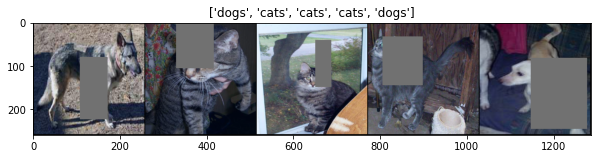

In [ ]:
# Load in Transformations
tfms = TransformCatalog.get("TorchvisionTransform").from_config(cfg)

ds = ImageFolder(root=f"{nbdev_path}/cats_and_dogs_filtered/train", 
                 loader=Loaders.get('pil_loader'), 
                 transform=tfms)

dl = torch.utils.data.DataLoader(ds, batch_size=5, shuffle=True)

images, targets = next(iter(dl))
targets = targets.data.numpy()

class_dict = {v:k for k,v in ds.class_to_idx.items()}

# display images
plt.figure(figsize=(10,10))
imshow_tensor(images, title=[class_dict[t] for t in targets], normalize=True);

In [ ]:
# export
@TransformCatalog.register()
class AlbumentationsTransform(ImageClassificationTransforms):
    "base class for creating albumentations transforms"
    def __init__(self, transforms: List):
        self.transforms = A.Compose(transforms)
        
    def __call__(self, image):
        return self.transforms(image=image)["image"]
    
    @classmethod
    def from_config(cls, config: DictConfig):
        "Loads in transformations from a `config`"
        transforms = [instantiate(t) for t in config]
        return cls(transforms=transforms)

In [ ]:
show_doc(AlbumentationsTransform)

<h2 id="AlbumentationsTransform" class="doc_header"><code>class</code> <code>AlbumentationsTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>AlbumentationsTransform</code>(**`transforms`**:`List`\[`T`\]) :: [`ImageClassificationTransforms`](/lightning_cv/data.transforms.html#ImageClassificationTransforms)

base class for creating albumentations transforms

Similar to `TorchvisionTransform` but using image-augmentations from `Albumentations`. Note this class requires the images to be loaded in via `cv2` use the utility function `cv2_loader` to load in images.

In [ ]:
show_doc(AlbumentationsTransform.from_config)

<h4 id="AlbumentationsTransform.from_config" class="doc_header"><code>AlbumentationsTransform.from_config</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>AlbumentationsTransform.from_config</code>(**`config`**:`DictConfig`)

Loads in transformations from a `config`

In [ ]:
# collaspe_ouput

tfms = [
    dict(_target_="albumentations.Resize", height=IMG_SIZE, width=IMG_SIZE, interpolation=2),
    dict(_target_="albumentations.Cutout", p=1.0),
    dict(_target_="albumentations.Normalize", mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, p=1.0), 
    dict(_target_="albumentations.pytorch.ToTensorV2", p=1.0),
]

# create config file
cfg = OmegaConf.create(tfms)
print(OmegaConf.to_yaml(cfg))

- _target_: albumentations.Resize
  height: 255
  width: 255
  interpolation: 2
- _target_: albumentations.Cutout
  p: 1.0
- _target_: albumentations.Normalize
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225
  p: 1.0
- _target_: albumentations.pytorch.ToTensorV2
  p: 1.0



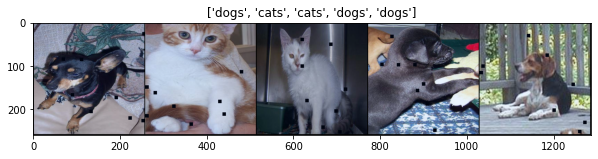

In [ ]:
# Load in Transformations
tfms = TransformCatalog.get("AlbumentationsTransform").from_config(cfg)

# note: for `AlbumentationsTransform` we need to use `cv2_loader`
ds = ImageFolder(root=f"{nbdev_path}/cats_and_dogs_filtered/train", 
                 loader=Loaders.get('cv2_loader'), 
                 transform=tfms)

dl = torch.utils.data.DataLoader(ds, batch_size=5, shuffle=True)


images, targets = next(iter(dl))
targets = targets.data.numpy()

class_dict = {v:k for k,v in ds.class_to_idx.items()}

plt.figure(figsize=(10,10))
imshow_tensor(images, title=[class_dict[t] for t in targets], normalize=True);

In [ ]:
# export
# modified from : https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/transforms_factory.py
@TransformCatalog.register()
class ImagenetNoAugmentTransform(TorchvisionTransform):
    "The default image transform without data augmentation. This can also be used for validation datasets"

    def __init__(self, 
                 img_size: Union[Tuple, int] = 224, 
                 crop_pct: int = DEFAULT_CROP_PCT, 
                 interpolation: str ='bilinear', 
                 mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN, 
                 std: Union[Tuple, List]  = IMAGENET_DEFAULT_STD,):
        
        if isinstance(img_size, tuple):
            assert len(img_size) == 2
            if img_size[-1] == img_size[-2]:
                scale_size = int(math.floor(img_size[0] / crop_pct))
            else: scale_size = tuple([int(x / crop_pct) for x in img_size])
        else: scale_size = int(math.floor(img_size / crop_pct))
            
        tfl = [
            T.Resize(scale_size, _pil_interp(interpolation)),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize(mean=torch.tensor(mean), std=torch.tensor(std))
        ]
        
        self.transforms = T.Compose(tfl)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

In [ ]:
show_doc(ImagenetNoAugmentTransform)

<h2 id="ImagenetNoAugmentTransform" class="doc_header"><code>class</code> <code>ImagenetNoAugmentTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ImagenetNoAugmentTransform</code>(**`img_size`**:`Union`\[`Tuple`, `int`\]=*`224`*, **`crop_pct`**:`int`=*`0.875`*, **`interpolation`**:`str`=*`'bilinear'`*, **`mean`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.229, 0.224, 0.225)`*) :: [`TorchvisionTransform`](/lightning_cv/data.transforms.html#TorchvisionTransform)

The default image transform without data augmentation. This can also be used for validation datasets

> Note : `ImagenetNoAugmentTransform` uses `pil_loader`

In [ ]:
# collaspe_ouput
tfms = dict(img_size=IMG_SIZE, crop_pct=DEFAULT_CROP_PCT, interpolation="bilinear",
            mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)

# create transform config
cfg = OmegaConf.create(tfms)
print(OmegaConf.to_yaml(cfg))

img_size: 255
crop_pct: 0.875
interpolation: bilinear
mean:
- 0.485
- 0.456
- 0.406
std:
- 0.229
- 0.224
- 0.225



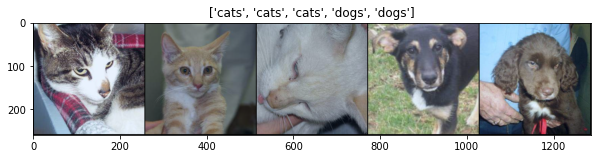

In [ ]:
# Load in Transformations
tfms = TransformCatalog.get("ImagenetNoAugmentTransform").from_config(cfg)

ds = ImageFolder(root=f"{nbdev_path}/cats_and_dogs_filtered/train", 
                 loader=Loaders.get("pil_loader"),  # use PIL Loader
                 transform=tfms)

dl = torch.utils.data.DataLoader(ds, batch_size=5, shuffle=True)

images, targets = next(iter(dl))
targets = targets.data.numpy()

class_dict = {v:k for k,v in ds.class_to_idx.items()}

# display image batch
plt.figure(figsize=(10,10))
imshow_tensor(images, title=[class_dict[t] for t in targets], normalize=True);

In [ ]:
# export
# modified from : https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/transforms_factory.py
@TransformCatalog.register()
class GenericImageTransform(TorchvisionTransform):
    """
    Default transform for images used in the classification task. This is similar to
    `transforms_imagenet_train` from timm library.
    """

    def __init__(self,
                 img_size: Union[Tuple, int] = 224,
                 interpolation: str = 'random',
                 scale: Optional[Union[List, Tuple]] = None,
                 ratio: Optional[Union[List, Tuple]] = None,
                 hflip: float = 0.5,
                 vflip: float = 0.5,
                 color_jitter: Optional[Union[List, Tuple, float]] = 0.4,
                 re_prob: float = 0.,
                 re_mode: str = 'const',
                 re_count: int = 1,
                 re_num_splits: int = 0,
                 mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN,
                 std: Union[Tuple, List]  = IMAGENET_DEFAULT_STD,):

        # default imagenet scale range
        scale = tuple(ifnone(scale, (0.08, 1.0)))
        # default imagenet ratio range
        ratio = tuple(ifnone(ratio, (3./4., 4./3.)))

        tfl = [RandomResizedCropAndInterpolation(
            img_size, scale=scale, 
            ratio=ratio, interpolation=interpolation)]

        if hflip > 0.: 
            tfl += [T.RandomHorizontalFlip(p=hflip)]

        if vflip > 0.: 
            tfl += [T.RandomVerticalFlip(p=vflip)]

        if color_jitter is not None:
            if isinstance(color_jitter, (list, tuple)):
                assert len(color_jitter) in (3, 4)
            else:
                # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
                color_jitter = (float(color_jitter),) * 3

            tfl += [T.ColorJitter(*color_jitter)]

        tfl += [T.ToTensor(), T.Normalize(mean, std)]

        if re_prob > 0.:
            tfl += [RandomErasing(re_prob, mode=re_mode, 
                                  max_count=re_count,num_splits=re_num_splits, 
                                  device='cpu')]
        
        # Compose Transformations
        self.transforms = T.Compose(tfl)
    
    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

In [ ]:
show_doc(GenericImageTransform)

<h2 id="GenericImageTransform" class="doc_header"><code>class</code> <code>GenericImageTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>GenericImageTransform</code>(**`img_size`**:`Union`\[`Tuple`, `int`\]=*`224`*, **`interpolation`**:`str`=*`'random'`*, **`scale`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`ratio`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`hflip`**:`float`=*`0.5`*, **`vflip`**:`float`=*`0.5`*, **`color_jitter`**:`Union`\[`List`\[`T`\], `Tuple`, `float`, `NoneType`\]=*`0.4`*, **`re_prob`**:`float`=*`0.0`*, **`re_mode`**:`str`=*`'const'`*, **`re_count`**:`int`=*`1`*, **`re_num_splits`**:`int`=*`0`*, **`mean`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.229, 0.224, 0.225)`*) :: [`TorchvisionTransform`](/lightning_cv/data.transforms.html#TorchvisionTransform)

Default transform for images used in the classification task. This is similar to
`transforms_imagenet_train` from timm library.

Transformations used in the above utility class :
1. `RandomResizedCropAndInterpolation`
2. `T.RandomHorizontalFlip` & `T.RandomVerticalFlip`
3. `T.ColorJitter`
4. `T.Normalize, T.ToTensor`
5. `RandomErasing`

> Note: This class doesn't implement `auto-augment` transformations.

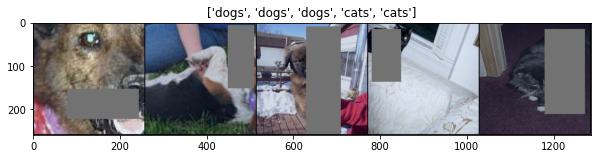

In [ ]:
# collaspe_ouput
tfms = dict(img_size=IMG_SIZE, scale=None, ratio=None, hflip=0.5, vflip=0.5, color_jitter=0.4, re_prob=1.0)

cfg = OmegaConf.create(tfms)

# Load in Transformations
tfms = TransformCatalog.get("GenericImageTransform").from_config(cfg)

ds = ImageFolder(root=f"{nbdev_path}/cats_and_dogs_filtered/train", 
                 loader=Loaders.get("pil_loader"), transform=tfms)
dl = torch.utils.data.DataLoader(ds, batch_size=5, shuffle=True)

images, targets = next(iter(dl))
targets = targets.data.numpy()

class_dict = {v:k for k,v in ds.class_to_idx.items()}

plt.figure(figsize=(10,10))
imshow_tensor(images, title=[class_dict[t] for t in targets], normalize=True);

In [ ]:
# export
# inspired from : https://docs.fast.ai/vision.augment.html#aug_transforms
@TransformCatalog.register()
class AugTransforms(AlbumentationsTransform):
    """
    Utility func to easily create a list of flip, affine, lighting, cutout transforms 
    using Albumentations Library.
    
    * `border_mode` and `interpolation` are OpenCV flag.
    * `do_flip` and `flip_vert` applies Horizontal/ Vertical flips with a prob of 0.5
    * `shift_limit`, `scale_limit`, `max_rotate` are parameters for `albumentations.ShiftScaleRotate`
    * `max_lighting` parameter for `albumentations.HueSaturationValue`
    * `p_shift`, `p_lighting`, `p_cutout` probablities for `ShiftScaleRotate`, `HueSaturationValue` & `CutOut`.
    """

    def __init__(self,
                 img_size: int = 224,
                 scale: Optional[Union[List, Tuple]] = None,
                 ratio: Optional[Union[List, Tuple]] = None,
                 interpolation: int = 1,
                 do_flip: bool = True,
                 flip_vert: bool = False,
                 shift_limit: float = 0.0625,
                 scale_limit: float = 0.1,
                 max_rotate: float = 45,
                 border_mode: int = 4,
                 max_lighting: Optional[Union[List, Tuple, float]] = 0.4,
                 p_shift: float = 0.5,
                 p_lighting: float = 0.75,
                 p_cutout: Optional[float] = 0.5,
                 mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN,
                 std: Union[Tuple, List] = IMAGENET_DEFAULT_STD):

        # default imagenet scale range
        scale = tuple(ifnone(scale, (0.08, 1.0)))
        # default imagenet ratio range
        ratio = tuple(ifnone(ratio, (3./4., 4./3.)))

        tfl = [A.RandomResizedCrop(img_size, img_size, scale, ratio, interpolation, p=1.0)]

        if do_flip:
            tfl += [A.HorizontalFlip(p=0.5)]
        if flip_vert:
            tfl += [A.VerticalFlip(p=0.5)]

        tfl += [A.ShiftScaleRotate(
            shift_limit, scale_limit, max_rotate, 
            interpolation, border_mode, 
            p=p_shift)]

        if max_lighting is not None:
            if isinstance(max_lighting, (list, tuple)):
                assert len(max_lighting) in (3, 4)
            else:
                # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
                max_lighting = (float(max_lighting),) * 3

            tfl += [A.HueSaturationValue(*max_lighting, p=p_lighting, always_apply=False)]
        
        if p_cutout is not None:
            tfl += [A.Cutout(p=p_cutout)]
        
        tfl += [A.Normalize(mean, std, max_pixel_value=255.0, p=1.0), ToTensorV2(p=0.5)]
        self.transforms = A.Compose(tfl)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

In [ ]:
show_doc(AugTransforms)

<h2 id="AugTransforms" class="doc_header"><code>class</code> <code>AugTransforms</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>AugTransforms</code>(**`img_size`**:`int`=*`224`*, **`scale`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`ratio`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`interpolation`**:`int`=*`1`*, **`do_flip`**:`bool`=*`True`*, **`flip_vert`**:`bool`=*`False`*, **`shift_limit`**:`float`=*`0.0625`*, **`scale_limit`**:`float`=*`0.1`*, **`max_rotate`**:`float`=*`45`*, **`border_mode`**:`int`=*`4`*, **`max_lighting`**:`Union`\[`List`\[`T`\], `Tuple`, `float`, `NoneType`\]=*`0.4`*, **`p_shift`**:`float`=*`0.5`*, **`p_lighting`**:`float`=*`0.75`*, **`p_cutout`**:`Optional`\[`float`\]=*`0.5`*, **`mean`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.229, 0.224, 0.225)`*) :: [`AlbumentationsTransform`](/lightning_cv/data.transforms.html#AlbumentationsTransform)

Utility func to easily create a list of flip, affine, lighting, cutout transforms 
using Albumentations Library.

* `border_mode` and `interpolation` are OpenCV flag.
* `do_flip` and `flip_vert` applies Horizontal/ Vertical flips with a prob of 0.5
* `shift_limit`, `scale_limit`, `max_rotate` are parameters for `albumentations.ShiftScaleRotate`
* `max_lighting` parameter for `albumentations.HueSaturationValue`
* `p_shift`, `p_lighting`, `p_cutout` probablities for `ShiftScaleRotate`, `HueSaturationValue` & `CutOut`.

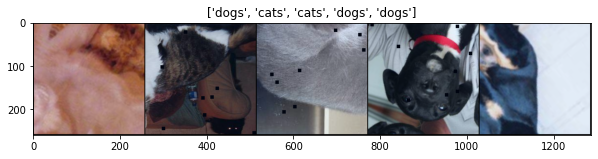

In [ ]:
# collaspe_ouput
cfg = dict(img_size=255, do_flip=True, flip_vert=True)

image = cv2_loader("images/puppy.jpg")
tfms = TransformCatalog.get("AugTransforms").from_config(cfg)
ds = ImageFolder(root=f"{nbdev_path}/cats_and_dogs_filtered/train", 
                 loader=Loaders.get("cv2_loader"), transform=tfms)
dl = torch.utils.data.DataLoader(ds, batch_size=5, shuffle=True)

images, targets = next(iter(dl))
targets = targets.data.numpy()

class_dict = {v:k for k,v in ds.class_to_idx.items()}

plt.figure(figsize=(10,10))
imshow_tensor(images, title=[class_dict[t] for t in targets], normalize=True);

## Registery of Transform -

In [ ]:
print(TransformCatalog)

Registry of TRANSFORMS:
╒════════════════════════════╤═══════════════════════════════════════════════╕
│ Names                      │ Objects                                       │
╞════════════════════════════╪═══════════════════════════════════════════════╡
│ TorchvisionTransform       │ <class '__main__.TorchvisionTransform'>       │
├────────────────────────────┼───────────────────────────────────────────────┤
│ AlbumentationsTransform    │ <class '__main__.AlbumentationsTransform'>    │
├────────────────────────────┼───────────────────────────────────────────────┤
│ ImagenetNoAugmentTransform │ <class '__main__.ImagenetNoAugmentTransform'> │
├────────────────────────────┼───────────────────────────────────────────────┤
│ GenericImageTransform      │ <class '__main__.GenericImageTransform'>      │
├────────────────────────────┼───────────────────────────────────────────────┤
│ AugTransforms              │ <class '__main__.AugTransforms'>              │
╘═══════════════════════════

## Export -

In [ ]:
# hide
notebook2script()

Converted 00a_utils.common.ipynb.
Converted 00b_utils.data.ipynb.
Converted 01a_data.transforms.ipynb.
Converted 01b_data.datasets.ipynb.
Converted index.ipynb.
